### Cab-Driver Agent

In [17]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [18]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
print("\nData shape:\n", np.shape(Time_matrix))
print("dimensions = ",len(Time_matrix.shape))


Data shape:
 (5, 5, 24, 7)
dimensions =  4


#### Tracking the state-action pairs for checking convergence


In [19]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [23]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor =0.9
        self.learning_rate =0.001        
        self.epsilon_max = 1
        self.epsilon_decay =  .995 #.999
        self.epsilon_min = 0.001
        self.epsilon = 1

        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state,env):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        possible_actions_index,actions = env.requests(state) # Find possible action indexes and append 0
        possible_actions_index.append(0)
        if np.random.rand() <= self.epsilon:
            return random.sample(possible_actions_index,1)[0]
        else:
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            # Give action with max q_value only amongst possible action
            return np.where(q_value[0] == np.max(np.array([q_value[0][i] for i in possible_actions_index])))[0][0]    
        
        
        
        


    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self,env):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                done.append(done_boolean)
                update_output[i] = next_state
                
                # Write your code from here
                
            # 1. Predict the target from earlier model           
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # Find possible actions from next state
                next_possible_actions_index,_ = env.requests(update_output[i])
                next_possible_actions_index.append(0)
                if not done[i]:
                    # Only take the max q_value from valid actions from next state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(np.array([target_qval[i][j] for j in next_possible_actions_index]))
                else:
                    target[i][actions[i]] = rewards[i]
                
                
        # 4. Fit your model and track the loss values
            #print("Training Model")
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            #print("Model Training Model")

    def save(self, name):
        self.model.save(name)

In [24]:
Episodes = 5000

### DQN block

In [25]:
#Under Test
agent = DQNAgent(36,21)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
# every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")

Initial State is  [3, 9, 3]
episode 0, reward -89.0, memory_length 133, epsilon 0.995, time 732.0, rides 132
Initial State is  [0, 16, 4]
episode 1, reward -140.0, memory_length 268, epsilon 0.990025, time 732.0, rides 134
Initial State is  [4, 8, 6]
episode 2, reward -208.0, memory_length 401, epsilon 0.985074875, time 730.0, rides 132
Initial State is  [1, 19, 5]
episode 3, reward -392.0, memory_length 510, epsilon 0.9801495006250001, time 724.0, rides 108
Initial State is  [4, 17, 6]
episode 4, reward -443.0, memory_length 657, epsilon 0.9752487531218751, time 732.0, rides 146
Initial State is  [0, 9, 6]
episode 5, reward -236.0, memory_length 779, epsilon 0.9703725093562657, time 725.0, rides 121
Initial State is  [4, 19, 5]
episode 6, reward -52.0, memory_length 905, epsilon 0.9655206468094844, time 727.0, rides 125
Initial State is  [1, 16, 5]
episode 7, reward 71.0, memory_length 1018, epsilon 0.960693043575437, time 731.0, rides 112
Initial State is  [2, 13, 6]
episode 8, rewar

episode 66, reward 349.0, memory_length 2000, epsilon 0.7147372386831305, time 724.0, rides 126
Initial State is  [0, 5, 1]
episode 67, reward 113.0, memory_length 2000, epsilon 0.7111635524897149, time 721.0, rides 125
Initial State is  [4, 3, 5]
episode 68, reward 246.0, memory_length 2000, epsilon 0.7076077347272662, time 731.0, rides 134
Initial State is  [0, 2, 6]
episode 69, reward 34.0, memory_length 2000, epsilon 0.7040696960536299, time 724.0, rides 125
Initial State is  [3, 3, 1]
episode 70, reward 371.0, memory_length 2000, epsilon 0.7005493475733617, time 730.0, rides 124
Initial State is  [0, 1, 3]
episode 71, reward 65.0, memory_length 2000, epsilon 0.697046600835495, time 731.0, rides 129
Initial State is  [3, 17, 1]
episode 72, reward 338.0, memory_length 2000, epsilon 0.6935613678313175, time 724.0, rides 118
Initial State is  [4, 12, 1]
episode 73, reward 191.0, memory_length 2000, epsilon 0.6900935609921609, time 731.0, rides 143
Initial State is  [2, 4, 6]
episode 7

episode 132, reward 375.0, memory_length 2000, epsilon 0.5134164023722473, time 724.0, rides 114
Initial State is  [2, 20, 3]
episode 133, reward 457.0, memory_length 2000, epsilon 0.510849320360386, time 724.0, rides 117
Initial State is  [3, 20, 4]
episode 134, reward 391.0, memory_length 2000, epsilon 0.5082950737585841, time 732.0, rides 114
Initial State is  [3, 3, 2]
episode 135, reward 181.0, memory_length 2000, epsilon 0.5057535983897912, time 742.0, rides 118
Initial State is  [2, 21, 4]
episode 136, reward 640.0, memory_length 2000, epsilon 0.5032248303978422, time 731.0, rides 138
Initial State is  [4, 12, 5]
episode 137, reward 96.0, memory_length 2000, epsilon 0.500708706245853, time 734.0, rides 122
Initial State is  [3, 18, 4]
episode 138, reward 365.0, memory_length 2000, epsilon 0.4982051627146237, time 734.0, rides 119
Initial State is  [3, 1, 1]
episode 139, reward 673.0, memory_length 2000, epsilon 0.49571413690105054, time 726.0, rides 113
Initial State is  [3, 3, 

episode 198, reward 415.0, memory_length 2000, epsilon 0.36880183088056995, time 742.0, rides 122
Initial State is  [0, 10, 1]
episode 199, reward 469.0, memory_length 2000, epsilon 0.3669578217261671, time 731.0, rides 117
Initial State is  [0, 2, 3]
episode 200, reward 834.0, memory_length 2000, epsilon 0.36512303261753626, time 728.0, rides 125
Initial State is  [3, 8, 0]
episode 201, reward 567.0, memory_length 2000, epsilon 0.3632974174544486, time 725.0, rides 114
Initial State is  [0, 22, 2]
episode 202, reward 659.0, memory_length 2000, epsilon 0.3614809303671764, time 734.0, rides 128
Initial State is  [3, 23, 3]
episode 203, reward 310.0, memory_length 2000, epsilon 0.3596735257153405, time 733.0, rides 115
Initial State is  [2, 7, 1]
episode 204, reward 444.0, memory_length 2000, epsilon 0.3578751580867638, time 736.0, rides 111
Initial State is  [0, 18, 2]
episode 205, reward 454.0, memory_length 2000, epsilon 0.35608578229633, time 733.0, rides 122
Initial State is  [1, 7,

episode 264, reward 755.0, memory_length 2000, epsilon 0.2649210072611673, time 733.0, rides 126
Initial State is  [2, 20, 3]
episode 265, reward 646.0, memory_length 2000, epsilon 0.26359640222486147, time 728.0, rides 114
Initial State is  [4, 23, 6]
episode 266, reward 719.0, memory_length 2000, epsilon 0.26227842021373715, time 729.0, rides 127
Initial State is  [0, 16, 1]
episode 267, reward 633.0, memory_length 2000, epsilon 0.2609670281126685, time 730.0, rides 120
Initial State is  [2, 11, 3]
episode 268, reward 669.0, memory_length 2000, epsilon 0.25966219297210513, time 726.0, rides 121
Initial State is  [2, 14, 4]
episode 269, reward 926.0, memory_length 2000, epsilon 0.2583638820072446, time 730.0, rides 131
Initial State is  [3, 3, 0]
episode 270, reward 495.0, memory_length 2000, epsilon 0.2570720625972084, time 723.0, rides 115
Initial State is  [3, 3, 4]
episode 271, reward 730.0, memory_length 2000, epsilon 0.25578670228422234, time 721.0, rides 118
Initial State is  [

episode 329, reward 525.0, memory_length 2000, epsilon 0.1912566947289212, time 735.0, rides 119
Initial State is  [3, 21, 1]
episode 330, reward 720.0, memory_length 2000, epsilon 0.1903004112552766, time 728.0, rides 113
Initial State is  [2, 16, 4]
episode 331, reward 1065.0, memory_length 2000, epsilon 0.18934890919900021, time 731.0, rides 121
Initial State is  [0, 22, 0]
episode 332, reward 809.0, memory_length 2000, epsilon 0.18840216465300522, time 731.0, rides 123
Initial State is  [1, 12, 0]
episode 333, reward 1185.0, memory_length 2000, epsilon 0.18746015382974018, time 724.0, rides 114
Initial State is  [3, 0, 5]
episode 334, reward 968.0, memory_length 2000, epsilon 0.1865228530605915, time 733.0, rides 126
Initial State is  [3, 3, 2]
episode 335, reward 724.0, memory_length 2000, epsilon 0.18559023879528855, time 728.0, rides 121
Initial State is  [4, 8, 6]
episode 336, reward 450.0, memory_length 2000, epsilon 0.1846622876013121, time 728.0, rides 130
Initial State is  

episode 394, reward 790.0, memory_length 2000, epsilon 0.13807558583895513, time 733.0, rides 125
Initial State is  [0, 22, 0]
episode 395, reward 975.0, memory_length 2000, epsilon 0.13738520790976036, time 728.0, rides 123
Initial State is  [2, 21, 3]
episode 396, reward 714.0, memory_length 2000, epsilon 0.13669828187021155, time 729.0, rides 113
Initial State is  [0, 3, 1]
episode 397, reward 984.0, memory_length 2000, epsilon 0.13601479046086049, time 730.0, rides 124
Initial State is  [4, 13, 1]
episode 398, reward 870.0, memory_length 2000, epsilon 0.1353347165085562, time 732.0, rides 127
Initial State is  [0, 0, 4]
episode 399, reward 991.0, memory_length 2000, epsilon 0.1346580429260134, time 728.0, rides 125
Initial State is  [3, 0, 3]
episode 400, reward 764.0, memory_length 2000, epsilon 0.13398475271138335, time 726.0, rides 118
Initial State is  [0, 1, 3]
episode 401, reward 947.0, memory_length 2000, epsilon 0.13331482894782642, time 734.0, rides 125
Initial State is  [

episode 459, reward 912.0, memory_length 2000, epsilon 0.0996820918179746, time 730.0, rides 115
Initial State is  [1, 11, 3]
episode 460, reward 1052.0, memory_length 2000, epsilon 0.09918368135888474, time 732.0, rides 128
Initial State is  [2, 14, 6]
episode 461, reward 888.0, memory_length 2000, epsilon 0.09868776295209031, time 725.0, rides 115
Initial State is  [0, 19, 3]
episode 462, reward 821.0, memory_length 2000, epsilon 0.09819432413732986, time 731.0, rides 117
Initial State is  [2, 7, 3]
episode 463, reward 920.0, memory_length 2000, epsilon 0.09770335251664321, time 732.0, rides 114
Initial State is  [1, 12, 4]
episode 464, reward 1039.0, memory_length 2000, epsilon 0.09721483575406, time 730.0, rides 115
Initial State is  [2, 23, 0]
episode 465, reward 1064.0, memory_length 2000, epsilon 0.09672876157528969, time 732.0, rides 122
Initial State is  [2, 0, 0]
episode 466, reward 1002.0, memory_length 2000, epsilon 0.09624511776741324, time 734.0, rides 122
Initial State i

episode 524, reward 929.0, memory_length 2000, epsilon 0.07196434741762824, time 732.0, rides 132
Initial State is  [2, 1, 5]
episode 525, reward 1056.0, memory_length 2000, epsilon 0.0716045256805401, time 732.0, rides 114
Initial State is  [1, 12, 5]
episode 526, reward 838.0, memory_length 2000, epsilon 0.0712465030521374, time 729.0, rides 110
Initial State is  [4, 3, 6]
episode 527, reward 772.0, memory_length 2000, epsilon 0.0708902705368767, time 731.0, rides 115
Initial State is  [2, 7, 6]
episode 528, reward 1172.0, memory_length 2000, epsilon 0.07053581918419231, time 736.0, rides 117
Initial State is  [3, 12, 2]
episode 529, reward 1185.0, memory_length 2000, epsilon 0.07018314008827135, time 726.0, rides 120
Initial State is  [1, 15, 0]
episode 530, reward 969.0, memory_length 2000, epsilon 0.06983222438783, time 727.0, rides 124
Initial State is  [3, 22, 3]
episode 531, reward 879.0, memory_length 2000, epsilon 0.06948306326589085, time 726.0, rides 116
Initial State is  [

episode 589, reward 1051.0, memory_length 2000, epsilon 0.05195383849590569, time 737.0, rides 114
Initial State is  [1, 11, 6]
episode 590, reward 1053.0, memory_length 2000, epsilon 0.05169406930342616, time 731.0, rides 116
Initial State is  [2, 17, 1]
episode 591, reward 856.0, memory_length 2000, epsilon 0.05143559895690903, time 734.0, rides 125
Initial State is  [2, 2, 6]
episode 592, reward 1117.0, memory_length 2000, epsilon 0.051178420962124486, time 725.0, rides 131
Initial State is  [3, 22, 1]
episode 593, reward 1140.0, memory_length 2000, epsilon 0.05092252885731386, time 725.0, rides 122
Initial State is  [2, 20, 0]
episode 594, reward 880.0, memory_length 2000, epsilon 0.05066791621302729, time 722.0, rides 125
Initial State is  [1, 3, 3]
episode 595, reward 1021.0, memory_length 2000, epsilon 0.05041457663196215, time 724.0, rides 123
Initial State is  [1, 19, 5]
episode 596, reward 1089.0, memory_length 2000, epsilon 0.050162503748802344, time 726.0, rides 118
Initial

episode 654, reward 1053.0, memory_length 2000, epsilon 0.03750748018035199, time 731.0, rides 123
Initial State is  [3, 12, 1]
episode 655, reward 768.0, memory_length 2000, epsilon 0.037319942779450235, time 735.0, rides 114
Initial State is  [3, 12, 5]
episode 656, reward 1229.0, memory_length 2000, epsilon 0.037133343065552986, time 725.0, rides 117
Initial State is  [2, 14, 3]
episode 657, reward 1327.0, memory_length 2000, epsilon 0.03694767635022522, time 730.0, rides 134
Initial State is  [0, 11, 2]
episode 658, reward 1059.0, memory_length 2000, epsilon 0.036762937968474095, time 728.0, rides 110
Initial State is  [3, 0, 1]
episode 659, reward 838.0, memory_length 2000, epsilon 0.03657912327863173, time 724.0, rides 115
Initial State is  [4, 15, 0]
episode 660, reward 625.0, memory_length 2000, epsilon 0.036396227662238566, time 727.0, rides 114
Initial State is  [2, 5, 1]
episode 661, reward 1452.0, memory_length 2000, epsilon 0.03621424652392737, time 739.0, rides 133
Initia

episode 719, reward 1119.0, memory_length 2000, epsilon 0.02707809682994571, time 723.0, rides 124
Initial State is  [0, 9, 2]
episode 720, reward 1079.0, memory_length 2000, epsilon 0.02694270634579598, time 736.0, rides 128
Initial State is  [1, 13, 0]
episode 721, reward 1072.0, memory_length 2000, epsilon 0.026807992814067, time 729.0, rides 119
Initial State is  [4, 18, 2]
episode 722, reward 895.0, memory_length 2000, epsilon 0.026673952849996664, time 731.0, rides 114
Initial State is  [0, 22, 2]
episode 723, reward 1387.0, memory_length 2000, epsilon 0.02654058308574668, time 733.0, rides 124
Initial State is  [4, 19, 5]
episode 724, reward 973.0, memory_length 2000, epsilon 0.026407880170317945, time 738.0, rides 123
Initial State is  [1, 8, 2]
episode 725, reward 1105.0, memory_length 2000, epsilon 0.026275840769466357, time 729.0, rides 116
Initial State is  [4, 9, 6]
episode 726, reward 1121.0, memory_length 2000, epsilon 0.026144461565619025, time 734.0, rides 119
Initial 

episode 784, reward 1052.0, memory_length 2000, epsilon 0.01954872266561937, time 730.0, rides 113
Initial State is  [2, 3, 6]
episode 785, reward 1022.0, memory_length 2000, epsilon 0.019450979052291272, time 738.0, rides 111
Initial State is  [4, 14, 1]
episode 786, reward 1159.0, memory_length 2000, epsilon 0.019353724157029815, time 726.0, rides 120
Initial State is  [0, 10, 3]
episode 787, reward 946.0, memory_length 2000, epsilon 0.019256955536244666, time 733.0, rides 112
Initial State is  [0, 9, 3]
episode 788, reward 1098.0, memory_length 2000, epsilon 0.019160670758563442, time 731.0, rides 117
Initial State is  [1, 22, 4]
episode 789, reward 1080.0, memory_length 2000, epsilon 0.019064867404770626, time 731.0, rides 130
Initial State is  [1, 2, 4]
episode 790, reward 1232.0, memory_length 2000, epsilon 0.018969543067746772, time 725.0, rides 120
Initial State is  [0, 20, 2]
episode 791, reward 976.0, memory_length 2000, epsilon 0.018874695352408037, time 729.0, rides 120
Ini

episode 849, reward 1218.0, memory_length 2000, epsilon 0.014112977003416188, time 735.0, rides 120
Initial State is  [1, 15, 0]
episode 850, reward 1179.0, memory_length 2000, epsilon 0.014042412118399107, time 728.0, rides 111
Initial State is  [3, 7, 0]
episode 851, reward 807.0, memory_length 2000, epsilon 0.013972200057807112, time 728.0, rides 118
Initial State is  [1, 4, 6]
episode 852, reward 1166.0, memory_length 2000, epsilon 0.013902339057518077, time 730.0, rides 113
Initial State is  [4, 0, 1]
episode 853, reward 1102.0, memory_length 2000, epsilon 0.013832827362230486, time 731.0, rides 119
Initial State is  [0, 14, 4]
episode 854, reward 1033.0, memory_length 2000, epsilon 0.013763663225419333, time 731.0, rides 122
Initial State is  [4, 23, 5]
episode 855, reward 1148.0, memory_length 2000, epsilon 0.013694844909292236, time 736.0, rides 118
Initial State is  [2, 8, 3]
episode 856, reward 1036.0, memory_length 2000, epsilon 0.013626370684745774, time 730.0, rides 122
In

episode 914, reward 1104.0, memory_length 2000, epsilon 0.010188702520663827, time 722.0, rides 120
Initial State is  [0, 6, 4]
episode 915, reward 1103.0, memory_length 2000, epsilon 0.010137759008060509, time 734.0, rides 129
Initial State is  [4, 21, 6]
episode 916, reward 1082.0, memory_length 2000, epsilon 0.010087070213020206, time 731.0, rides 113
Initial State is  [1, 0, 3]
episode 917, reward 867.0, memory_length 2000, epsilon 0.010036634861955105, time 724.0, rides 114
Initial State is  [3, 8, 3]
episode 918, reward 1157.0, memory_length 2000, epsilon 0.00998645168764533, time 726.0, rides 133
Initial State is  [0, 19, 1]
episode 919, reward 913.0, memory_length 2000, epsilon 0.009936519429207103, time 725.0, rides 114
Initial State is  [0, 16, 6]
episode 920, reward 844.0, memory_length 2000, epsilon 0.009886836832061067, time 737.0, rides 115
Initial State is  [3, 16, 4]
episode 921, reward 1182.0, memory_length 2000, epsilon 0.009837402647900761, time 730.0, rides 116
Init

episode 979, reward 944.0, memory_length 2000, epsilon 0.00735561738883676, time 725.0, rides 116
Initial State is  [3, 14, 6]
episode 980, reward 1226.0, memory_length 2000, epsilon 0.007318839301892576, time 729.0, rides 119
Initial State is  [1, 14, 3]
episode 981, reward 1034.0, memory_length 2000, epsilon 0.0072822451053831125, time 728.0, rides 122
Initial State is  [3, 18, 5]
episode 982, reward 947.0, memory_length 2000, epsilon 0.007245833879856197, time 730.0, rides 111
Initial State is  [2, 4, 5]
episode 983, reward 919.0, memory_length 2000, epsilon 0.007209604710456916, time 729.0, rides 122
Initial State is  [1, 9, 1]
episode 984, reward 1122.0, memory_length 2000, epsilon 0.0071735566869046315, time 732.0, rides 119
Initial State is  [3, 11, 6]
episode 985, reward 1055.0, memory_length 2000, epsilon 0.007137688903470108, time 730.0, rides 125
Initial State is  [1, 1, 1]
episode 986, reward 1235.0, memory_length 2000, epsilon 0.0071020004589527575, time 730.0, rides 116
I

episode 1043, reward 946.0, memory_length 2000, epsilon 0.005336988887577507, time 729.0, rides 127
Initial State is  [3, 0, 4]
episode 1044, reward 908.0, memory_length 2000, epsilon 0.00531030394313962, time 730.0, rides 112
Initial State is  [3, 23, 5]
episode 1045, reward 1180.0, memory_length 2000, epsilon 0.005283752423423922, time 725.0, rides 110
Initial State is  [0, 3, 6]
episode 1046, reward 1210.0, memory_length 2000, epsilon 0.005257333661306802, time 733.0, rides 120
Initial State is  [1, 18, 6]
episode 1047, reward 888.0, memory_length 2000, epsilon 0.005231046993000268, time 728.0, rides 119
Initial State is  [0, 9, 6]
episode 1048, reward 905.0, memory_length 2000, epsilon 0.005204891758035267, time 725.0, rides 114
Initial State is  [3, 23, 3]
episode 1049, reward 1088.0, memory_length 2000, epsilon 0.005178867299245091, time 728.0, rides 113
Initial State is  [2, 9, 2]
episode 1050, reward 1226.0, memory_length 2000, epsilon 0.0051529729627488655, time 724.0, rides 1

episode 1107, reward 991.0, memory_length 2000, epsilon 0.003872339856794843, time 731.0, rides 115
Initial State is  [1, 5, 6]
episode 1108, reward 1057.0, memory_length 2000, epsilon 0.0038529781575108685, time 731.0, rides 116
Initial State is  [2, 18, 4]
episode 1109, reward 1083.0, memory_length 2000, epsilon 0.003833713266723314, time 724.0, rides 114
Initial State is  [2, 13, 3]
episode 1110, reward 1133.0, memory_length 2000, epsilon 0.003814544700389697, time 729.0, rides 111
Initial State is  [1, 13, 5]
episode 1111, reward 1216.0, memory_length 2000, epsilon 0.0037954719768877486, time 727.0, rides 112
Initial State is  [2, 1, 1]
episode 1112, reward 1280.0, memory_length 2000, epsilon 0.0037764946170033096, time 734.0, rides 128
Initial State is  [2, 1, 0]
episode 1113, reward 1123.0, memory_length 2000, epsilon 0.003757612143918293, time 727.0, rides 122
Initial State is  [1, 0, 3]
episode 1114, reward 1187.0, memory_length 2000, epsilon 0.003738824083198702, time 727.0, r

episode 1171, reward 1073.0, memory_length 2000, epsilon 0.0028096397205219286, time 730.0, rides 113
Initial State is  [3, 23, 2]
episode 1172, reward 1228.0, memory_length 2000, epsilon 0.002795591521919319, time 729.0, rides 123
Initial State is  [0, 16, 4]
episode 1173, reward 961.0, memory_length 2000, epsilon 0.0027816135643097223, time 725.0, rides 119
Initial State is  [1, 12, 5]
episode 1174, reward 885.0, memory_length 2000, epsilon 0.0027677054964881736, time 732.0, rides 123
Initial State is  [0, 1, 3]
episode 1175, reward 1036.0, memory_length 2000, epsilon 0.0027538669690057326, time 733.0, rides 108
Initial State is  [4, 14, 3]
episode 1176, reward 1314.0, memory_length 2000, epsilon 0.002740097634160704, time 733.0, rides 125
Initial State is  [0, 14, 3]
episode 1177, reward 860.0, memory_length 2000, epsilon 0.0027263971459899005, time 735.0, rides 123
Initial State is  [3, 21, 2]
episode 1178, reward 1287.0, memory_length 2000, epsilon 0.002712765160259951, time 720.0

episode 1235, reward 1161.0, memory_length 2000, epsilon 0.0020385801998455055, time 728.0, rides 116
Initial State is  [3, 21, 2]
episode 1236, reward 956.0, memory_length 2000, epsilon 0.002028387298846278, time 734.0, rides 113
Initial State is  [3, 7, 3]
episode 1237, reward 794.0, memory_length 2000, epsilon 0.0020182453623520465, time 738.0, rides 110
Initial State is  [2, 16, 6]
episode 1238, reward 1082.0, memory_length 2000, epsilon 0.0020081541355402863, time 728.0, rides 107
Initial State is  [0, 0, 5]
episode 1239, reward 1234.0, memory_length 2000, epsilon 0.0019981133648625847, time 742.0, rides 124
Initial State is  [2, 9, 2]
episode 1240, reward 1074.0, memory_length 2000, epsilon 0.001988122798038272, time 733.0, rides 118
Initial State is  [4, 9, 5]
episode 1241, reward 1244.0, memory_length 2000, epsilon 0.0019781821840480804, time 724.0, rides 118
Initial State is  [3, 21, 3]
episode 1242, reward 1274.0, memory_length 2000, epsilon 0.00196829127312784, time 721.0, r

episode 1298, reward 1273.0, memory_length 2000, epsilon 0.001486558103577649, time 732.0, rides 118
Initial State is  [0, 6, 3]
episode 1299, reward 1137.0, memory_length 2000, epsilon 0.0014791253130597608, time 735.0, rides 111
Initial State is  [2, 12, 1]
episode 1300, reward 1109.0, memory_length 2000, epsilon 0.001471729686494462, time 726.0, rides 119
Initial State is  [1, 17, 6]
episode 1301, reward 1078.0, memory_length 2000, epsilon 0.0014643710380619897, time 734.0, rides 120
Initial State is  [2, 8, 0]
episode 1302, reward 873.0, memory_length 2000, epsilon 0.0014570491828716798, time 733.0, rides 119
Initial State is  [0, 14, 3]
episode 1303, reward 1203.0, memory_length 2000, epsilon 0.0014497639369573214, time 728.0, rides 113
Initial State is  [1, 13, 6]
episode 1304, reward 1241.0, memory_length 2000, epsilon 0.0014425151172725347, time 726.0, rides 125
Initial State is  [4, 19, 3]
episode 1305, reward 1061.0, memory_length 2000, epsilon 0.001435302541686172, time 730.

episode 1361, reward 972.0, memory_length 2000, epsilon 0.0010840167070590872, time 739.0, rides 121
Initial State is  [4, 1, 0]
episode 1362, reward 852.0, memory_length 2000, epsilon 0.0010785966235237919, time 734.0, rides 108
Initial State is  [0, 1, 2]
episode 1363, reward 890.0, memory_length 2000, epsilon 0.001073203640406173, time 725.0, rides 121
Initial State is  [4, 15, 0]
episode 1364, reward 854.0, memory_length 2000, epsilon 0.001067837622204142, time 731.0, rides 110
Initial State is  [2, 7, 0]
episode 1365, reward 1211.0, memory_length 2000, epsilon 0.0010624984340931213, time 728.0, rides 111
Initial State is  [0, 4, 5]
episode 1366, reward 1187.0, memory_length 2000, epsilon 0.0010571859419226557, time 727.0, rides 121
Initial State is  [3, 12, 3]
episode 1367, reward 1063.0, memory_length 2000, epsilon 0.0010519000122130424, time 735.0, rides 113
Initial State is  [4, 15, 0]
episode 1368, reward 1242.0, memory_length 2000, epsilon 0.0010466405121519772, time 726.0, r

episode 1424, reward 1630.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 117
Initial State is  [0, 22, 6]
episode 1425, reward 1221.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 112
Initial State is  [2, 3, 5]
episode 1426, reward 1027.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 123
Initial State is  [4, 5, 3]
episode 1427, reward 1209.0, memory_length 2000, epsilon 0.0009954703940636294, time 733.0, rides 125
Initial State is  [2, 14, 0]
episode 1428, reward 998.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 110
Initial State is  [4, 0, 1]
episode 1429, reward 1087.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 122
Initial State is  [3, 19, 6]
episode 1430, reward 1333.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 130
Initial State is  [3, 1, 6]
episode 1431, reward 1015.0, memory_length 2000, epsilon 0.0009954703940636294, time 729

episode 1487, reward 1141.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 122
Initial State is  [3, 5, 0]
episode 1488, reward 837.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 108
Initial State is  [4, 2, 3]
episode 1489, reward 1107.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 108
Initial State is  [2, 17, 2]
episode 1490, reward 1384.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 123
Initial State is  [3, 1, 3]
episode 1491, reward 1206.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 124
Initial State is  [2, 15, 6]
episode 1492, reward 1038.0, memory_length 2000, epsilon 0.0009954703940636294, time 733.0, rides 115
Initial State is  [1, 14, 3]
episode 1493, reward 785.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 108
Initial State is  [1, 10, 0]
episode 1494, reward 1102.0, memory_length 2000, epsilon 0.0009954703940636294, time 734

episode 1550, reward 1264.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 120
Initial State is  [1, 2, 3]
episode 1551, reward 1253.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 126
Initial State is  [2, 19, 0]
episode 1552, reward 1023.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 118
Initial State is  [4, 14, 6]
episode 1553, reward 774.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 111
Initial State is  [3, 0, 4]
episode 1554, reward 1317.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 121
Initial State is  [4, 9, 1]
episode 1555, reward 1082.0, memory_length 2000, epsilon 0.0009954703940636294, time 739.0, rides 116
Initial State is  [3, 17, 5]
episode 1556, reward 1001.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 105
Initial State is  [1, 3, 2]
episode 1557, reward 1181.0, memory_length 2000, epsilon 0.0009954703940636294, time 731

episode 1613, reward 1320.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 124
Initial State is  [1, 19, 0]
episode 1614, reward 983.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 117
Initial State is  [2, 18, 1]
episode 1615, reward 988.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 119
Initial State is  [4, 14, 3]
episode 1616, reward 1096.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 124
Initial State is  [2, 11, 6]
episode 1617, reward 979.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 111
Initial State is  [4, 2, 1]
episode 1618, reward 961.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 113
Initial State is  [3, 11, 6]
episode 1619, reward 980.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 114
Initial State is  [1, 22, 6]
episode 1620, reward 1264.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.

episode 1676, reward 1227.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 128
Initial State is  [1, 6, 3]
episode 1677, reward 892.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 109
Initial State is  [2, 20, 5]
episode 1678, reward 928.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 118
Initial State is  [1, 11, 4]
episode 1679, reward 856.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 103
Initial State is  [3, 17, 0]
episode 1680, reward 1084.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 113
Initial State is  [1, 14, 0]
episode 1681, reward 978.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 112
Initial State is  [3, 9, 4]
episode 1682, reward 929.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 123
Initial State is  [4, 4, 1]
episode 1683, reward 1231.0, memory_length 2000, epsilon 0.0009954703940636294, time 736.0,

episode 1739, reward 1199.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 126
Initial State is  [0, 11, 0]
episode 1740, reward 1306.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 127
Initial State is  [4, 5, 1]
episode 1741, reward 1242.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 117
Initial State is  [3, 4, 4]
episode 1742, reward 1300.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 124
Initial State is  [0, 18, 6]
episode 1743, reward 1063.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 114
Initial State is  [1, 6, 0]
episode 1744, reward 1151.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 117
Initial State is  [2, 0, 2]
episode 1745, reward 1024.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 117
Initial State is  [2, 7, 6]
episode 1746, reward 978.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.

episode 1802, reward 923.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 123
Initial State is  [1, 5, 1]
episode 1803, reward 1323.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 120
Initial State is  [4, 0, 4]
episode 1804, reward 1105.0, memory_length 2000, epsilon 0.0009954703940636294, time 740.0, rides 121
Initial State is  [4, 18, 1]
episode 1805, reward 1213.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 123
Initial State is  [3, 18, 2]
episode 1806, reward 1154.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 114
Initial State is  [2, 17, 4]
episode 1807, reward 1037.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 119
Initial State is  [1, 12, 3]
episode 1808, reward 1152.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 106
Initial State is  [2, 3, 1]
episode 1809, reward 1061.0, memory_length 2000, epsilon 0.0009954703940636294, time 73

episode 1865, reward 929.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 110
Initial State is  [0, 13, 2]
episode 1866, reward 1252.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 116
Initial State is  [3, 19, 4]
episode 1867, reward 1006.0, memory_length 2000, epsilon 0.0009954703940636294, time 722.0, rides 115
Initial State is  [1, 14, 3]
episode 1868, reward 1037.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 121
Initial State is  [0, 15, 5]
episode 1869, reward 1242.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 113
Initial State is  [4, 18, 5]
episode 1870, reward 891.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 129
Initial State is  [2, 11, 6]
episode 1871, reward 784.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 109
Initial State is  [2, 9, 5]
episode 1872, reward 1249.0, memory_length 2000, epsilon 0.0009954703940636294, time 73

episode 1928, reward 962.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 117
Initial State is  [1, 20, 2]
episode 1929, reward 1188.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 118
Initial State is  [3, 21, 4]
episode 1930, reward 1187.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 116
Initial State is  [2, 8, 6]
episode 1931, reward 1102.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 123
Initial State is  [0, 4, 0]
episode 1932, reward 1127.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 117
Initial State is  [1, 12, 1]
episode 1933, reward 1111.0, memory_length 2000, epsilon 0.0009954703940636294, time 733.0, rides 122
Initial State is  [4, 5, 5]
episode 1934, reward 1023.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 121
Initial State is  [1, 1, 3]
episode 1935, reward 1405.0, memory_length 2000, epsilon 0.0009954703940636294, time 730

episode 1991, reward 1233.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 120
Initial State is  [4, 10, 4]
episode 1992, reward 1364.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 115
Initial State is  [0, 17, 4]
episode 1993, reward 1117.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 114
Initial State is  [3, 17, 4]
episode 1994, reward 942.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 117
Initial State is  [1, 3, 3]
episode 1995, reward 1446.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 124
Initial State is  [1, 15, 5]
episode 1996, reward 1047.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 117
Initial State is  [1, 10, 3]
episode 1997, reward 1235.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 116
Initial State is  [0, 7, 3]
episode 1998, reward 1231.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 2054, reward 995.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 125
Initial State is  [4, 20, 6]
episode 2055, reward 1326.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 112
Initial State is  [0, 0, 6]
episode 2056, reward 1336.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 116
Initial State is  [0, 17, 2]
episode 2057, reward 1282.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 120
Initial State is  [0, 1, 1]
episode 2058, reward 1065.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 112
Initial State is  [3, 19, 0]
episode 2059, reward 1144.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 121
Initial State is  [0, 14, 5]
episode 2060, reward 1113.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 117
Initial State is  [0, 11, 5]
episode 2061, reward 856.0, memory_length 2000, epsilon 0.0009954703940636294, time 72

episode 2117, reward 992.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 106
Initial State is  [4, 2, 5]
episode 2118, reward 1536.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 126
Initial State is  [1, 19, 2]
episode 2119, reward 1157.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 115
Initial State is  [3, 10, 4]
episode 2120, reward 1092.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 127
Initial State is  [3, 1, 4]
episode 2121, reward 1018.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 129
Initial State is  [0, 12, 2]
episode 2122, reward 1136.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 105
Initial State is  [3, 13, 3]
episode 2123, reward 1025.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 117
Initial State is  [4, 14, 1]
episode 2124, reward 1124.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 2180, reward 1075.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 122
Initial State is  [0, 0, 4]
episode 2181, reward 1158.0, memory_length 2000, epsilon 0.0009954703940636294, time 736.0, rides 112
Initial State is  [0, 15, 5]
episode 2182, reward 1152.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 136
Initial State is  [4, 21, 5]
episode 2183, reward 1204.0, memory_length 2000, epsilon 0.0009954703940636294, time 722.0, rides 113
Initial State is  [4, 9, 1]
episode 2184, reward 991.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 121
Initial State is  [0, 15, 4]
episode 2185, reward 906.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 109
Initial State is  [1, 20, 4]
episode 2186, reward 1230.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 119
Initial State is  [3, 7, 4]
episode 2187, reward 1002.0, memory_length 2000, epsilon 0.0009954703940636294, time 732

episode 2243, reward 1421.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 111
Initial State is  [3, 18, 4]
episode 2244, reward 1349.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 121
Initial State is  [4, 19, 0]
episode 2245, reward 861.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 117
Initial State is  [1, 21, 5]
episode 2246, reward 1059.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 121
Initial State is  [1, 0, 4]
episode 2247, reward 1056.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 120
Initial State is  [4, 16, 3]
episode 2248, reward 1102.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 108
Initial State is  [2, 5, 5]
episode 2249, reward 1178.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 131
Initial State is  [4, 5, 3]
episode 2250, reward 1144.0, memory_length 2000, epsilon 0.0009954703940636294, time 72

episode 2306, reward 1015.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 123
Initial State is  [0, 23, 1]
episode 2307, reward 1333.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 126
Initial State is  [2, 15, 1]
episode 2308, reward 1126.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 111
Initial State is  [0, 0, 5]
episode 2309, reward 1066.0, memory_length 2000, epsilon 0.0009954703940636294, time 733.0, rides 112
Initial State is  [0, 3, 5]
episode 2310, reward 1241.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 128
Initial State is  [0, 10, 6]
episode 2311, reward 1236.0, memory_length 2000, epsilon 0.0009954703940636294, time 740.0, rides 122
Initial State is  [3, 0, 6]
episode 2312, reward 1245.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 123
Initial State is  [2, 12, 6]
episode 2313, reward 1243.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 2369, reward 1260.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 123
Initial State is  [1, 12, 2]
episode 2370, reward 1103.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 121
Initial State is  [2, 9, 2]
episode 2371, reward 1043.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 109
Initial State is  [0, 8, 4]
episode 2372, reward 1418.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 128
Initial State is  [2, 12, 0]
episode 2373, reward 1256.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 118
Initial State is  [2, 2, 5]
episode 2374, reward 984.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 108
Initial State is  [1, 17, 0]
episode 2375, reward 1349.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 125
Initial State is  [3, 22, 5]
episode 2376, reward 1091.0, memory_length 2000, epsilon 0.0009954703940636294, time 73

episode 2432, reward 1111.0, memory_length 2000, epsilon 0.0009954703940636294, time 739.0, rides 112
Initial State is  [3, 22, 4]
episode 2433, reward 1161.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 116
Initial State is  [4, 4, 0]
episode 2434, reward 1236.0, memory_length 2000, epsilon 0.0009954703940636294, time 736.0, rides 110
Initial State is  [4, 20, 4]
episode 2435, reward 1035.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 113
Initial State is  [4, 19, 2]
episode 2436, reward 789.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 110
Initial State is  [3, 16, 5]
episode 2437, reward 1236.0, memory_length 2000, epsilon 0.0009954703940636294, time 722.0, rides 124
Initial State is  [3, 20, 6]
episode 2438, reward 1125.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 111
Initial State is  [1, 18, 2]
episode 2439, reward 1072.0, memory_length 2000, epsilon 0.0009954703940636294, time 

episode 2495, reward 1183.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 124
Initial State is  [4, 2, 2]
episode 2496, reward 1093.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 119
Initial State is  [2, 8, 4]
episode 2497, reward 1324.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 124
Initial State is  [0, 0, 5]
episode 2498, reward 1464.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 119
Initial State is  [4, 3, 6]
episode 2499, reward 1231.0, memory_length 2000, epsilon 0.0009954703940636294, time 738.0, rides 115
Initial State is  [2, 11, 5]
episode 2500, reward 957.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 112
Initial State is  [4, 8, 1]
episode 2501, reward 1037.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 114
Initial State is  [4, 0, 0]
episode 2502, reward 1002.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0

episode 2558, reward 1032.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 118
Initial State is  [1, 19, 4]
episode 2559, reward 1232.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 115
Initial State is  [1, 23, 4]
episode 2560, reward 822.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 114
Initial State is  [2, 17, 6]
episode 2561, reward 1302.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 123
Initial State is  [0, 16, 6]
episode 2562, reward 932.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 113
Initial State is  [4, 7, 4]
episode 2563, reward 836.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 119
Initial State is  [3, 3, 3]
episode 2564, reward 1022.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 114
Initial State is  [2, 13, 6]
episode 2565, reward 1018.0, memory_length 2000, epsilon 0.0009954703940636294, time 738

episode 2621, reward 1181.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 131
Initial State is  [2, 12, 5]
episode 2622, reward 1092.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 130
Initial State is  [0, 19, 3]
episode 2623, reward 1084.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 120
Initial State is  [3, 11, 0]
episode 2624, reward 1095.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 119
Initial State is  [3, 8, 3]
episode 2625, reward 1058.0, memory_length 2000, epsilon 0.0009954703940636294, time 738.0, rides 126
Initial State is  [0, 10, 5]
episode 2626, reward 1078.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 117
Initial State is  [4, 0, 2]
episode 2627, reward 793.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 106
Initial State is  [1, 21, 0]
episode 2628, reward 1487.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 2684, reward 1151.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 119
Initial State is  [4, 17, 0]
episode 2685, reward 1200.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 117
Initial State is  [1, 18, 3]
episode 2686, reward 1258.0, memory_length 2000, epsilon 0.0009954703940636294, time 721.0, rides 122
Initial State is  [4, 9, 3]
episode 2687, reward 1119.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 117
Initial State is  [0, 5, 5]
episode 2688, reward 979.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 117
Initial State is  [0, 5, 1]
episode 2689, reward 777.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 110
Initial State is  [1, 2, 4]
episode 2690, reward 898.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 126
Initial State is  [1, 8, 5]
episode 2691, reward 918.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, 

episode 2747, reward 1339.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 118
Initial State is  [4, 12, 3]
episode 2748, reward 1046.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 111
Initial State is  [4, 21, 5]
episode 2749, reward 1137.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 122
Initial State is  [2, 8, 6]
episode 2750, reward 1172.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 118
Initial State is  [3, 0, 4]
episode 2751, reward 1010.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 120
Initial State is  [3, 6, 2]
episode 2752, reward 1051.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 117
Initial State is  [3, 0, 4]
episode 2753, reward 1166.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 114
Initial State is  [1, 7, 1]
episode 2754, reward 1170.0, memory_length 2000, epsilon 0.0009954703940636294, time 733

episode 2810, reward 1004.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 109
Initial State is  [2, 21, 6]
episode 2811, reward 1392.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 128
Initial State is  [3, 19, 4]
episode 2812, reward 849.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 115
Initial State is  [0, 23, 2]
episode 2813, reward 1244.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 123
Initial State is  [4, 14, 2]
episode 2814, reward 970.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 110
Initial State is  [3, 14, 6]
episode 2815, reward 998.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 118
Initial State is  [1, 7, 4]
episode 2816, reward 1218.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 131
Initial State is  [3, 14, 4]
episode 2817, reward 925.0, memory_length 2000, epsilon 0.0009954703940636294, time 728

episode 2873, reward 1117.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 116
Initial State is  [2, 4, 0]
episode 2874, reward 879.0, memory_length 2000, epsilon 0.0009954703940636294, time 722.0, rides 115
Initial State is  [4, 17, 3]
episode 2875, reward 1009.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 117
Initial State is  [1, 11, 2]
episode 2876, reward 1046.0, memory_length 2000, epsilon 0.0009954703940636294, time 737.0, rides 120
Initial State is  [1, 7, 6]
episode 2877, reward 1049.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 109
Initial State is  [0, 19, 6]
episode 2878, reward 1260.0, memory_length 2000, epsilon 0.0009954703940636294, time 739.0, rides 113
Initial State is  [2, 16, 4]
episode 2879, reward 1154.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 107
Initial State is  [0, 23, 2]
episode 2880, reward 1057.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 2936, reward 917.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 110
Initial State is  [1, 0, 5]
episode 2937, reward 1072.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 121
Initial State is  [0, 14, 2]
episode 2938, reward 1089.0, memory_length 2000, epsilon 0.0009954703940636294, time 733.0, rides 115
Initial State is  [1, 22, 4]
episode 2939, reward 1254.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 121
Initial State is  [4, 5, 5]
episode 2940, reward 1215.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 120
Initial State is  [1, 23, 2]
episode 2941, reward 1114.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 112
Initial State is  [4, 18, 1]
episode 2942, reward 832.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 113
Initial State is  [0, 8, 1]
episode 2943, reward 1252.0, memory_length 2000, epsilon 0.0009954703940636294, time 728

episode 2999, reward 1143.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 124
Initial State is  [1, 22, 0]
episode 3000, reward 1249.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 118
Initial State is  [1, 19, 1]
episode 3001, reward 1240.0, memory_length 2000, epsilon 0.0009954703940636294, time 741.0, rides 114
Initial State is  [2, 16, 5]
episode 3002, reward 1043.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 121
Initial State is  [3, 16, 1]
episode 3003, reward 980.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 121
Initial State is  [2, 2, 6]
episode 3004, reward 821.0, memory_length 2000, epsilon 0.0009954703940636294, time 722.0, rides 121
Initial State is  [3, 10, 2]
episode 3005, reward 1259.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 119
Initial State is  [2, 12, 1]
episode 3006, reward 1180.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 3062, reward 1183.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 117
Initial State is  [0, 0, 4]
episode 3063, reward 1331.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 128
Initial State is  [1, 6, 3]
episode 3064, reward 1270.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 120
Initial State is  [2, 10, 4]
episode 3065, reward 1027.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 126
Initial State is  [2, 10, 4]
episode 3066, reward 1207.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 120
Initial State is  [4, 10, 3]
episode 3067, reward 1408.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 112
Initial State is  [3, 12, 0]
episode 3068, reward 1242.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 127
Initial State is  [1, 6, 6]
episode 3069, reward 1389.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 3125, reward 1007.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 113
Initial State is  [2, 1, 5]
episode 3126, reward 1198.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 117
Initial State is  [0, 0, 6]
episode 3127, reward 1268.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 124
Initial State is  [1, 8, 1]
episode 3128, reward 1277.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 113
Initial State is  [1, 20, 4]
episode 3129, reward 961.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 106
Initial State is  [3, 22, 0]
episode 3130, reward 1030.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 116
Initial State is  [0, 13, 4]
episode 3131, reward 1083.0, memory_length 2000, epsilon 0.0009954703940636294, time 736.0, rides 121
Initial State is  [3, 2, 2]
episode 3132, reward 1271.0, memory_length 2000, epsilon 0.0009954703940636294, time 729

episode 3188, reward 787.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 113
Initial State is  [3, 4, 4]
episode 3189, reward 849.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 108
Initial State is  [4, 16, 0]
episode 3190, reward 1373.0, memory_length 2000, epsilon 0.0009954703940636294, time 738.0, rides 135
Initial State is  [0, 21, 1]
episode 3191, reward 1127.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 117
Initial State is  [0, 5, 1]
episode 3192, reward 863.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 122
Initial State is  [1, 19, 3]
episode 3193, reward 1084.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 118
Initial State is  [2, 3, 4]
episode 3194, reward 1015.0, memory_length 2000, epsilon 0.0009954703940636294, time 741.0, rides 120
Initial State is  [3, 5, 6]
episode 3195, reward 1037.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0

episode 3251, reward 1031.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 114
Initial State is  [4, 6, 1]
episode 3252, reward 1422.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 133
Initial State is  [2, 3, 4]
episode 3253, reward 1426.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 122
Initial State is  [2, 9, 6]
episode 3254, reward 1254.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 114
Initial State is  [2, 8, 3]
episode 3255, reward 1122.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 121
Initial State is  [0, 8, 6]
episode 3256, reward 1432.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 118
Initial State is  [4, 17, 1]
episode 3257, reward 1215.0, memory_length 2000, epsilon 0.0009954703940636294, time 733.0, rides 117
Initial State is  [0, 20, 0]
episode 3258, reward 1286.0, memory_length 2000, epsilon 0.0009954703940636294, time 727

episode 3314, reward 835.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 114
Initial State is  [0, 6, 4]
episode 3315, reward 975.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 109
Initial State is  [1, 1, 0]
episode 3316, reward 1307.0, memory_length 2000, epsilon 0.0009954703940636294, time 733.0, rides 117
Initial State is  [3, 18, 1]
episode 3317, reward 1385.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 115
Initial State is  [3, 5, 1]
episode 3318, reward 1078.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 114
Initial State is  [4, 22, 4]
episode 3319, reward 1140.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 114
Initial State is  [0, 18, 3]
episode 3320, reward 1301.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 115
Initial State is  [3, 10, 3]
episode 3321, reward 987.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.

episode 3377, reward 1204.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 123
Initial State is  [3, 19, 1]
episode 3378, reward 1312.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 127
Initial State is  [0, 22, 0]
episode 3379, reward 1250.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 141
Initial State is  [1, 11, 0]
episode 3380, reward 1159.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 126
Initial State is  [0, 5, 0]
episode 3381, reward 1193.0, memory_length 2000, epsilon 0.0009954703940636294, time 738.0, rides 134
Initial State is  [3, 2, 5]
episode 3382, reward 1587.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 133
Initial State is  [1, 6, 4]
episode 3383, reward 1143.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 132
Initial State is  [3, 18, 1]
episode 3384, reward 1145.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 3440, reward 1373.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 122
Initial State is  [3, 3, 1]
episode 3441, reward 731.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 116
Initial State is  [1, 21, 0]
episode 3442, reward 1334.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 124
Initial State is  [0, 0, 0]
episode 3443, reward 1473.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 121
Initial State is  [0, 2, 4]
episode 3444, reward 1204.0, memory_length 2000, epsilon 0.0009954703940636294, time 738.0, rides 139
Initial State is  [3, 15, 3]
episode 3445, reward 1248.0, memory_length 2000, epsilon 0.0009954703940636294, time 736.0, rides 136
Initial State is  [0, 23, 0]
episode 3446, reward 1325.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 119
Initial State is  [0, 4, 5]
episode 3447, reward 1287.0, memory_length 2000, epsilon 0.0009954703940636294, time 727

episode 3503, reward 1267.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 123
Initial State is  [2, 13, 5]
episode 3504, reward 1155.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 131
Initial State is  [3, 10, 6]
episode 3505, reward 1138.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 118
Initial State is  [1, 17, 6]
episode 3506, reward 1079.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 124
Initial State is  [0, 1, 5]
episode 3507, reward 1533.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 125
Initial State is  [4, 4, 3]
episode 3508, reward 1193.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 122
Initial State is  [0, 17, 6]
episode 3509, reward 1016.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 119
Initial State is  [2, 5, 6]
episode 3510, reward 1096.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 3566, reward 1407.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 127
Initial State is  [0, 11, 5]
episode 3567, reward 1263.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 118
Initial State is  [4, 20, 1]
episode 3568, reward 1048.0, memory_length 2000, epsilon 0.0009954703940636294, time 733.0, rides 122
Initial State is  [4, 6, 1]
episode 3569, reward 1316.0, memory_length 2000, epsilon 0.0009954703940636294, time 733.0, rides 123
Initial State is  [1, 1, 5]
episode 3570, reward 1238.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 132
Initial State is  [0, 19, 6]
episode 3571, reward 1085.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 131
Initial State is  [1, 21, 6]
episode 3572, reward 1326.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 123
Initial State is  [4, 6, 1]
episode 3573, reward 1406.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 3629, reward 1395.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 123
Initial State is  [1, 1, 5]
episode 3630, reward 1128.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 121
Initial State is  [2, 9, 2]
episode 3631, reward 1191.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 130
Initial State is  [2, 0, 1]
episode 3632, reward 1144.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 120
Initial State is  [2, 21, 1]
episode 3633, reward 1435.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 141
Initial State is  [0, 10, 1]
episode 3634, reward 1360.0, memory_length 2000, epsilon 0.0009954703940636294, time 733.0, rides 132
Initial State is  [4, 18, 3]
episode 3635, reward 1045.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 127
Initial State is  [1, 19, 5]
episode 3636, reward 1259.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 3692, reward 1377.0, memory_length 2000, epsilon 0.0009954703940636294, time 738.0, rides 124
Initial State is  [2, 17, 3]
episode 3693, reward 1079.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 127
Initial State is  [4, 17, 1]
episode 3694, reward 1352.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 126
Initial State is  [3, 21, 1]
episode 3695, reward 847.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 119
Initial State is  [2, 1, 6]
episode 3696, reward 996.0, memory_length 2000, epsilon 0.0009954703940636294, time 722.0, rides 120
Initial State is  [4, 4, 1]
episode 3697, reward 1266.0, memory_length 2000, epsilon 0.0009954703940636294, time 736.0, rides 123
Initial State is  [3, 4, 0]
episode 3698, reward 1323.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 127
Initial State is  [1, 7, 2]
episode 3699, reward 895.0, memory_length 2000, epsilon 0.0009954703940636294, time 733.0

episode 3755, reward 1379.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 136
Initial State is  [1, 3, 6]
episode 3756, reward 1284.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 124
Initial State is  [0, 22, 0]
episode 3757, reward 1420.0, memory_length 2000, epsilon 0.0009954703940636294, time 743.0, rides 131
Initial State is  [2, 20, 1]
episode 3758, reward 1167.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 115
Initial State is  [2, 17, 5]
episode 3759, reward 1254.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 127
Initial State is  [4, 11, 5]
episode 3760, reward 955.0, memory_length 2000, epsilon 0.0009954703940636294, time 739.0, rides 114
Initial State is  [0, 22, 4]
episode 3761, reward 1446.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 127
Initial State is  [3, 10, 0]
episode 3762, reward 1401.0, memory_length 2000, epsilon 0.0009954703940636294, time 

episode 3818, reward 1233.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 122
Initial State is  [0, 2, 3]
episode 3819, reward 1238.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 127
Initial State is  [1, 21, 3]
episode 3820, reward 1465.0, memory_length 2000, epsilon 0.0009954703940636294, time 733.0, rides 123
Initial State is  [1, 20, 5]
episode 3821, reward 1266.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 117
Initial State is  [1, 9, 1]
episode 3822, reward 1259.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 120
Initial State is  [0, 10, 4]
episode 3823, reward 1286.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 130
Initial State is  [1, 10, 0]
episode 3824, reward 884.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 131
Initial State is  [4, 9, 1]
episode 3825, reward 1151.0, memory_length 2000, epsilon 0.0009954703940636294, time 72

episode 3881, reward 1243.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 123
Initial State is  [3, 17, 6]
episode 3882, reward 1146.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 117
Initial State is  [3, 21, 6]
episode 3883, reward 1360.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 114
Initial State is  [2, 23, 0]
episode 3884, reward 1133.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 123
Initial State is  [4, 11, 2]
episode 3885, reward 1308.0, memory_length 2000, epsilon 0.0009954703940636294, time 737.0, rides 116
Initial State is  [1, 19, 4]
episode 3886, reward 1029.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 129
Initial State is  [2, 13, 6]
episode 3887, reward 1312.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 123
Initial State is  [0, 6, 6]
episode 3888, reward 1436.0, memory_length 2000, epsilon 0.0009954703940636294, time

episode 3944, reward 1303.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 125
Initial State is  [2, 11, 4]
episode 3945, reward 1069.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 111
Initial State is  [2, 3, 0]
episode 3946, reward 1419.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 120
Initial State is  [3, 1, 4]
episode 3947, reward 1196.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 128
Initial State is  [1, 6, 0]
episode 3948, reward 1230.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 121
Initial State is  [2, 8, 5]
episode 3949, reward 1193.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 133
Initial State is  [3, 21, 4]
episode 3950, reward 1158.0, memory_length 2000, epsilon 0.0009954703940636294, time 737.0, rides 130
Initial State is  [3, 6, 0]
episode 3951, reward 1252.0, memory_length 2000, epsilon 0.0009954703940636294, time 732

episode 4007, reward 1263.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 116
Initial State is  [2, 5, 1]
episode 4008, reward 911.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 127
Initial State is  [1, 19, 5]
episode 4009, reward 1175.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 133
Initial State is  [3, 4, 5]
episode 4010, reward 1324.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 125
Initial State is  [1, 22, 0]
episode 4011, reward 867.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 122
Initial State is  [2, 4, 0]
episode 4012, reward 1341.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 122
Initial State is  [4, 9, 2]
episode 4013, reward 1370.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 127
Initial State is  [3, 17, 0]
episode 4014, reward 1017.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.

episode 4070, reward 1308.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 121
Initial State is  [0, 9, 1]
episode 4071, reward 972.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 124
Initial State is  [1, 8, 4]
episode 4072, reward 1209.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 128
Initial State is  [1, 20, 2]
episode 4073, reward 1223.0, memory_length 2000, epsilon 0.0009954703940636294, time 736.0, rides 114
Initial State is  [3, 14, 4]
episode 4074, reward 1214.0, memory_length 2000, epsilon 0.0009954703940636294, time 736.0, rides 133
Initial State is  [1, 1, 1]
episode 4075, reward 1328.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 121
Initial State is  [1, 16, 5]
episode 4076, reward 1640.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 126
Initial State is  [4, 10, 6]
episode 4077, reward 1256.0, memory_length 2000, epsilon 0.0009954703940636294, time 72

episode 4133, reward 1163.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 131
Initial State is  [2, 6, 5]
episode 4134, reward 1240.0, memory_length 2000, epsilon 0.0009954703940636294, time 739.0, rides 116
Initial State is  [3, 13, 4]
episode 4135, reward 1307.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 128
Initial State is  [3, 13, 6]
episode 4136, reward 1241.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 123
Initial State is  [1, 21, 2]
episode 4137, reward 1096.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 126
Initial State is  [1, 12, 4]
episode 4138, reward 1117.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 131
Initial State is  [2, 23, 4]
episode 4139, reward 908.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 122
Initial State is  [1, 20, 4]
episode 4140, reward 1298.0, memory_length 2000, epsilon 0.0009954703940636294, time 

episode 4196, reward 1170.0, memory_length 2000, epsilon 0.0009954703940636294, time 733.0, rides 119
Initial State is  [1, 16, 3]
episode 4197, reward 1388.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 126
Initial State is  [0, 0, 3]
episode 4198, reward 1242.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 128
Initial State is  [4, 19, 3]
episode 4199, reward 1182.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 123
Initial State is  [4, 6, 1]
episode 4200, reward 1027.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 131
Initial State is  [1, 22, 0]
episode 4201, reward 1051.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 117
Initial State is  [3, 7, 0]
episode 4202, reward 1375.0, memory_length 2000, epsilon 0.0009954703940636294, time 722.0, rides 123
Initial State is  [4, 15, 0]
episode 4203, reward 1143.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 4259, reward 1489.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 136
Initial State is  [3, 4, 1]
episode 4260, reward 1277.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 121
Initial State is  [2, 18, 3]
episode 4261, reward 898.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 115
Initial State is  [3, 9, 6]
episode 4262, reward 1039.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 113
Initial State is  [2, 5, 2]
episode 4263, reward 1320.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 120
Initial State is  [4, 2, 6]
episode 4264, reward 1169.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 117
Initial State is  [2, 18, 6]
episode 4265, reward 1414.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 125
Initial State is  [0, 6, 0]
episode 4266, reward 997.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0

episode 4322, reward 1245.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 129
Initial State is  [2, 5, 6]
episode 4323, reward 1291.0, memory_length 2000, epsilon 0.0009954703940636294, time 740.0, rides 117
Initial State is  [4, 21, 6]
episode 4324, reward 1246.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 125
Initial State is  [4, 2, 0]
episode 4325, reward 1341.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 120
Initial State is  [1, 1, 4]
episode 4326, reward 1345.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 129
Initial State is  [0, 22, 3]
episode 4327, reward 1232.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 121
Initial State is  [3, 18, 4]
episode 4328, reward 1219.0, memory_length 2000, epsilon 0.0009954703940636294, time 721.0, rides 119
Initial State is  [0, 4, 4]
episode 4329, reward 1042.0, memory_length 2000, epsilon 0.0009954703940636294, time 72

episode 4385, reward 1201.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 124
Initial State is  [3, 20, 3]
episode 4386, reward 941.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 127
Initial State is  [3, 6, 2]
episode 4387, reward 1401.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 128
Initial State is  [2, 19, 1]
episode 4388, reward 1279.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 124
Initial State is  [3, 0, 2]
episode 4389, reward 1180.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 114
Initial State is  [4, 9, 5]
episode 4390, reward 1242.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 125
Initial State is  [0, 7, 3]
episode 4391, reward 899.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 123
Initial State is  [0, 21, 3]
episode 4392, reward 1013.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.

episode 4448, reward 949.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 128
Initial State is  [0, 2, 4]
episode 4449, reward 1240.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 121
Initial State is  [2, 15, 0]
episode 4450, reward 1021.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 123
Initial State is  [1, 0, 0]
episode 4451, reward 1120.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 119
Initial State is  [4, 14, 4]
episode 4452, reward 1295.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 124
Initial State is  [0, 22, 1]
episode 4453, reward 1296.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 115
Initial State is  [4, 4, 1]
episode 4454, reward 1496.0, memory_length 2000, epsilon 0.0009954703940636294, time 736.0, rides 129
Initial State is  [3, 13, 3]
episode 4455, reward 1052.0, memory_length 2000, epsilon 0.0009954703940636294, time 73

episode 4511, reward 1191.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 122
Initial State is  [4, 10, 5]
episode 4512, reward 1296.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 124
Initial State is  [0, 19, 2]
episode 4513, reward 1131.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 132
Initial State is  [4, 15, 6]
episode 4514, reward 1292.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 110
Initial State is  [4, 21, 1]
episode 4515, reward 1153.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 118
Initial State is  [2, 6, 2]
episode 4516, reward 995.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 121
Initial State is  [4, 18, 3]
episode 4517, reward 1270.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 123
Initial State is  [3, 19, 6]
episode 4518, reward 1208.0, memory_length 2000, epsilon 0.0009954703940636294, time 

episode 4574, reward 1202.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 129
Initial State is  [3, 11, 0]
episode 4575, reward 1265.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 130
Initial State is  [2, 15, 6]
episode 4576, reward 1254.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 142
Initial State is  [3, 7, 0]
episode 4577, reward 1057.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 109
Initial State is  [1, 21, 4]
episode 4578, reward 1216.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 127
Initial State is  [1, 3, 6]
episode 4579, reward 1446.0, memory_length 2000, epsilon 0.0009954703940636294, time 733.0, rides 132
Initial State is  [3, 7, 5]
episode 4580, reward 1241.0, memory_length 2000, epsilon 0.0009954703940636294, time 737.0, rides 133
Initial State is  [0, 8, 0]
episode 4581, reward 1409.0, memory_length 2000, epsilon 0.0009954703940636294, time 73

episode 4637, reward 1093.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 125
Initial State is  [4, 18, 2]
episode 4638, reward 1325.0, memory_length 2000, epsilon 0.0009954703940636294, time 721.0, rides 119
Initial State is  [2, 8, 1]
episode 4639, reward 1355.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 123
Initial State is  [3, 6, 6]
episode 4640, reward 1257.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 122
Initial State is  [2, 18, 3]
episode 4641, reward 1245.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 128
Initial State is  [2, 22, 0]
episode 4642, reward 1347.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 126
Initial State is  [2, 15, 5]
episode 4643, reward 1102.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 126
Initial State is  [4, 21, 4]
episode 4644, reward 1243.0, memory_length 2000, epsilon 0.0009954703940636294, time 

episode 4700, reward 916.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 124
Initial State is  [3, 11, 5]
episode 4701, reward 1031.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 120
Initial State is  [0, 22, 2]
episode 4702, reward 1310.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 118
Initial State is  [4, 4, 6]
episode 4703, reward 1380.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 124
Initial State is  [4, 2, 1]
episode 4704, reward 1206.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 130
Initial State is  [3, 19, 2]
episode 4705, reward 1061.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 115
Initial State is  [1, 14, 2]
episode 4706, reward 1273.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 128
Initial State is  [0, 13, 2]
episode 4707, reward 1370.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 4763, reward 1335.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 129
Initial State is  [0, 0, 5]
episode 4764, reward 1253.0, memory_length 2000, epsilon 0.0009954703940636294, time 738.0, rides 120
Initial State is  [2, 3, 4]
episode 4765, reward 1734.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 122
Initial State is  [3, 9, 0]
episode 4766, reward 1041.0, memory_length 2000, epsilon 0.0009954703940636294, time 737.0, rides 125
Initial State is  [2, 14, 0]
episode 4767, reward 1184.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 120
Initial State is  [4, 0, 1]
episode 4768, reward 1134.0, memory_length 2000, epsilon 0.0009954703940636294, time 736.0, rides 119
Initial State is  [0, 16, 2]
episode 4769, reward 1365.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 120
Initial State is  [0, 4, 6]
episode 4770, reward 1178.0, memory_length 2000, epsilon 0.0009954703940636294, time 723

episode 4826, reward 999.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 115
Initial State is  [3, 11, 6]
episode 4827, reward 1164.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 129
Initial State is  [1, 23, 6]
episode 4828, reward 1407.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 130
Initial State is  [3, 4, 0]
episode 4829, reward 1334.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 131
Initial State is  [0, 5, 2]
episode 4830, reward 1088.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 121
Initial State is  [1, 5, 2]
episode 4831, reward 1220.0, memory_length 2000, epsilon 0.0009954703940636294, time 724.0, rides 127
Initial State is  [4, 15, 0]
episode 4832, reward 1218.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 126
Initial State is  [4, 8, 2]
episode 4833, reward 1289.0, memory_length 2000, epsilon 0.0009954703940636294, time 727

episode 4889, reward 1269.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 119
Initial State is  [0, 14, 4]
episode 4890, reward 1329.0, memory_length 2000, epsilon 0.0009954703940636294, time 738.0, rides 122
Initial State is  [1, 19, 4]
episode 4891, reward 1396.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 118
Initial State is  [2, 20, 4]
episode 4892, reward 1213.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 129
Initial State is  [3, 7, 2]
episode 4893, reward 1349.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 131
Initial State is  [4, 12, 0]
episode 4894, reward 1264.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 125
Initial State is  [3, 9, 6]
episode 4895, reward 1156.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 141
Initial State is  [2, 2, 2]
episode 4896, reward 966.0, memory_length 2000, epsilon 0.0009954703940636294, time 73

episode 4952, reward 1123.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 122
Initial State is  [3, 9, 5]
episode 4953, reward 1362.0, memory_length 2000, epsilon 0.0009954703940636294, time 736.0, rides 130
Initial State is  [0, 10, 4]
episode 4954, reward 1289.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 124
Initial State is  [2, 2, 5]
episode 4955, reward 1494.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 133
Initial State is  [1, 22, 4]
episode 4956, reward 999.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 125
Initial State is  [0, 17, 4]
episode 4957, reward 1355.0, memory_length 2000, epsilon 0.0009954703940636294, time 737.0, rides 125
Initial State is  [0, 18, 6]
episode 4958, reward 1272.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 134
Initial State is  [4, 22, 0]
episode 4959, reward 1398.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

In [ ]:

agent = DQNAgent(36,21)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")

Initial State is  [4, 14, 4]
episode 0, reward 55.0, memory_length 136, epsilon 0.995, time 729.0, rides 135
Initial State is  [1, 22, 4]
episode 1, reward -220.0, memory_length 239, epsilon 0.990025, time 724.0, rides 102
Initial State is  [2, 4, 3]
episode 2, reward -172.0, memory_length 361, epsilon 0.985074875, time 738.0, rides 121
Initial State is  [2, 20, 2]
episode 3, reward -146.0, memory_length 490, epsilon 0.9801495006250001, time 729.0, rides 128
Initial State is  [3, 11, 1]
episode 4, reward -173.0, memory_length 610, epsilon 0.9752487531218751, time 721.0, rides 119
Initial State is  [1, 6, 4]
episode 5, reward -389.0, memory_length 732, epsilon 0.9703725093562657, time 734.0, rides 121
Initial State is  [0, 21, 1]
episode 6, reward -75.0, memory_length 858, epsilon 0.9655206468094844, time 735.0, rides 125
Initial State is  [2, 16, 3]
episode 7, reward -263.0, memory_length 990, epsilon 0.960693043575437, time 734.0, rides 131
Initial State is  [4, 3, 5]
episode 8, rewar

episode 66, reward 108.0, memory_length 2000, epsilon 0.7147372386831305, time 729.0, rides 127
Initial State is  [0, 3, 3]
episode 67, reward 301.0, memory_length 2000, epsilon 0.7111635524897149, time 728.0, rides 116
Initial State is  [4, 18, 5]
episode 68, reward 188.0, memory_length 2000, epsilon 0.7076077347272662, time 728.0, rides 140
Initial State is  [1, 11, 1]
episode 69, reward 46.0, memory_length 2000, epsilon 0.7040696960536299, time 729.0, rides 124
Initial State is  [4, 18, 0]
episode 70, reward 61.0, memory_length 2000, epsilon 0.7005493475733617, time 725.0, rides 121
Initial State is  [4, 14, 6]
episode 71, reward 129.0, memory_length 2000, epsilon 0.697046600835495, time 734.0, rides 137
Initial State is  [2, 15, 5]
episode 72, reward 215.0, memory_length 2000, epsilon 0.6935613678313175, time 732.0, rides 120
Initial State is  [2, 2, 1]
episode 73, reward 49.0, memory_length 2000, epsilon 0.6900935609921609, time 736.0, rides 129
Initial State is  [2, 4, 4]
episode

episode 132, reward 433.0, memory_length 2000, epsilon 0.5134164023722473, time 730.0, rides 126
Initial State is  [0, 11, 3]
episode 133, reward 226.0, memory_length 2000, epsilon 0.510849320360386, time 741.0, rides 130
Initial State is  [4, 19, 6]
episode 134, reward 482.0, memory_length 2000, epsilon 0.5082950737585841, time 733.0, rides 125
Initial State is  [3, 7, 6]
episode 135, reward 431.0, memory_length 2000, epsilon 0.5057535983897912, time 726.0, rides 132
Initial State is  [0, 1, 5]
episode 136, reward 672.0, memory_length 2000, epsilon 0.5032248303978422, time 726.0, rides 133
Initial State is  [4, 2, 1]
episode 137, reward 569.0, memory_length 2000, epsilon 0.500708706245853, time 727.0, rides 123
Initial State is  [4, 11, 2]
episode 138, reward 459.0, memory_length 2000, epsilon 0.4982051627146237, time 737.0, rides 121
Initial State is  [1, 10, 4]
episode 139, reward 322.0, memory_length 2000, epsilon 0.49571413690105054, time 728.0, rides 124
Initial State is  [3, 0, 

episode 198, reward 443.0, memory_length 2000, epsilon 0.36880183088056995, time 726.0, rides 128
Initial State is  [3, 12, 0]
episode 199, reward 262.0, memory_length 2000, epsilon 0.3669578217261671, time 728.0, rides 125
Initial State is  [1, 23, 6]
episode 200, reward 491.0, memory_length 2000, epsilon 0.36512303261753626, time 742.0, rides 119
Initial State is  [0, 11, 3]
episode 201, reward 454.0, memory_length 2000, epsilon 0.3632974174544486, time 731.0, rides 130
Initial State is  [2, 9, 6]
episode 202, reward 493.0, memory_length 2000, epsilon 0.3614809303671764, time 735.0, rides 125
Initial State is  [0, 23, 6]
episode 203, reward 422.0, memory_length 2000, epsilon 0.3596735257153405, time 728.0, rides 135
Initial State is  [3, 22, 2]
episode 204, reward 791.0, memory_length 2000, epsilon 0.3578751580867638, time 738.0, rides 134
Initial State is  [2, 10, 4]
episode 205, reward 751.0, memory_length 2000, epsilon 0.35608578229633, time 733.0, rides 123
Initial State is  [2, 

episode 264, reward 593.0, memory_length 2000, epsilon 0.2649210072611673, time 733.0, rides 128
Initial State is  [3, 19, 6]
episode 265, reward 943.0, memory_length 2000, epsilon 0.26359640222486147, time 727.0, rides 136
Initial State is  [0, 5, 0]
episode 266, reward 898.0, memory_length 2000, epsilon 0.26227842021373715, time 736.0, rides 131
Initial State is  [2, 2, 3]
episode 267, reward 588.0, memory_length 2000, epsilon 0.2609670281126685, time 734.0, rides 117
Initial State is  [2, 21, 3]
episode 268, reward 254.0, memory_length 2000, epsilon 0.25966219297210513, time 737.0, rides 131
Initial State is  [0, 16, 6]
episode 269, reward 919.0, memory_length 2000, epsilon 0.2583638820072446, time 738.0, rides 129
Initial State is  [4, 13, 3]
episode 270, reward 890.0, memory_length 2000, epsilon 0.2570720625972084, time 730.0, rides 125
Initial State is  [2, 20, 2]
episode 271, reward 899.0, memory_length 2000, epsilon 0.25578670228422234, time 725.0, rides 125
Initial State is  [

episode 329, reward 360.0, memory_length 2000, epsilon 0.1912566947289212, time 731.0, rides 121
Initial State is  [0, 7, 2]
episode 330, reward 749.0, memory_length 2000, epsilon 0.1903004112552766, time 734.0, rides 128
Initial State is  [4, 1, 6]
episode 331, reward 718.0, memory_length 2000, epsilon 0.18934890919900021, time 729.0, rides 131
Initial State is  [1, 22, 5]
episode 332, reward 883.0, memory_length 2000, epsilon 0.18840216465300522, time 725.0, rides 122
Initial State is  [3, 18, 0]
episode 333, reward 773.0, memory_length 2000, epsilon 0.18746015382974018, time 741.0, rides 126
Initial State is  [2, 16, 6]
episode 334, reward 844.0, memory_length 2000, epsilon 0.1865228530605915, time 729.0, rides 134
Initial State is  [0, 22, 4]
episode 335, reward 1030.0, memory_length 2000, epsilon 0.18559023879528855, time 732.0, rides 135
Initial State is  [3, 9, 0]
episode 336, reward 695.0, memory_length 2000, epsilon 0.1846622876013121, time 730.0, rides 139
Initial State is  [

episode 394, reward 677.0, memory_length 2000, epsilon 0.13807558583895513, time 728.0, rides 135
Initial State is  [0, 10, 4]
episode 395, reward 865.0, memory_length 2000, epsilon 0.13738520790976036, time 730.0, rides 126
Initial State is  [3, 17, 0]
episode 396, reward 890.0, memory_length 2000, epsilon 0.13669828187021155, time 726.0, rides 124
Initial State is  [2, 8, 5]
episode 397, reward 987.0, memory_length 2000, epsilon 0.13601479046086049, time 728.0, rides 123
Initial State is  [4, 0, 0]
episode 398, reward 901.0, memory_length 2000, epsilon 0.1353347165085562, time 728.0, rides 127
Initial State is  [3, 1, 3]
episode 399, reward 1155.0, memory_length 2000, epsilon 0.1346580429260134, time 737.0, rides 131
Initial State is  [0, 2, 6]
episode 400, reward 1129.0, memory_length 2000, epsilon 0.13398475271138335, time 726.0, rides 119
Initial State is  [2, 23, 1]
episode 401, reward 952.0, memory_length 2000, epsilon 0.13331482894782642, time 733.0, rides 133
Initial State is 

episode 459, reward 910.0, memory_length 2000, epsilon 0.0996820918179746, time 727.0, rides 123
Initial State is  [0, 22, 4]
episode 460, reward 1031.0, memory_length 2000, epsilon 0.09918368135888474, time 727.0, rides 124
Initial State is  [2, 2, 2]
episode 461, reward 1078.0, memory_length 2000, epsilon 0.09868776295209031, time 731.0, rides 126
Initial State is  [0, 21, 2]
episode 462, reward 1082.0, memory_length 2000, epsilon 0.09819432413732986, time 724.0, rides 121
Initial State is  [1, 16, 2]
episode 463, reward 949.0, memory_length 2000, epsilon 0.09770335251664321, time 730.0, rides 122
Initial State is  [0, 8, 2]
episode 464, reward 933.0, memory_length 2000, epsilon 0.09721483575406, time 722.0, rides 121
Initial State is  [1, 0, 1]
episode 465, reward 811.0, memory_length 2000, epsilon 0.09672876157528969, time 725.0, rides 125
Initial State is  [2, 3, 6]
episode 466, reward 742.0, memory_length 2000, epsilon 0.09624511776741324, time 729.0, rides 117
Initial State is  

episode 524, reward 921.0, memory_length 2000, epsilon 0.07196434741762824, time 728.0, rides 117
Initial State is  [3, 12, 2]
episode 525, reward 909.0, memory_length 2000, epsilon 0.0716045256805401, time 730.0, rides 127
Initial State is  [1, 23, 3]
episode 526, reward 1044.0, memory_length 2000, epsilon 0.0712465030521374, time 726.0, rides 132
Initial State is  [3, 23, 1]
episode 527, reward 1082.0, memory_length 2000, epsilon 0.0708902705368767, time 729.0, rides 129
Initial State is  [4, 4, 0]
episode 528, reward 1153.0, memory_length 2000, epsilon 0.07053581918419231, time 725.0, rides 116
Initial State is  [4, 10, 2]
episode 529, reward 1175.0, memory_length 2000, epsilon 0.07018314008827135, time 722.0, rides 127
Initial State is  [0, 12, 4]
episode 530, reward 759.0, memory_length 2000, epsilon 0.06983222438783, time 726.0, rides 123
Initial State is  [3, 10, 0]
episode 531, reward 1136.0, memory_length 2000, epsilon 0.06948306326589085, time 730.0, rides 125
Initial State i

episode 589, reward 807.0, memory_length 2000, epsilon 0.05195383849590569, time 728.0, rides 140
Initial State is  [3, 10, 4]
episode 590, reward 1150.0, memory_length 2000, epsilon 0.05169406930342616, time 724.0, rides 128
Initial State is  [2, 19, 2]
episode 591, reward 1083.0, memory_length 2000, epsilon 0.05143559895690903, time 734.0, rides 120
Initial State is  [0, 17, 2]
episode 592, reward 1113.0, memory_length 2000, epsilon 0.051178420962124486, time 728.0, rides 122
Initial State is  [1, 3, 4]
episode 593, reward 1068.0, memory_length 2000, epsilon 0.05092252885731386, time 733.0, rides 122
Initial State is  [1, 21, 2]
episode 594, reward 1207.0, memory_length 2000, epsilon 0.05066791621302729, time 728.0, rides 123
Initial State is  [1, 20, 3]
episode 595, reward 781.0, memory_length 2000, epsilon 0.05041457663196215, time 728.0, rides 116
Initial State is  [3, 21, 6]
episode 596, reward 817.0, memory_length 2000, epsilon 0.050162503748802344, time 728.0, rides 123
Initial

episode 654, reward 725.0, memory_length 2000, epsilon 0.03750748018035199, time 727.0, rides 121
Initial State is  [4, 19, 2]
episode 655, reward 900.0, memory_length 2000, epsilon 0.037319942779450235, time 734.0, rides 124
Initial State is  [3, 7, 3]
episode 656, reward 1056.0, memory_length 2000, epsilon 0.037133343065552986, time 730.0, rides 124
Initial State is  [1, 21, 3]
episode 657, reward 1062.0, memory_length 2000, epsilon 0.03694767635022522, time 731.0, rides 123
Initial State is  [4, 4, 5]
episode 658, reward 957.0, memory_length 2000, epsilon 0.036762937968474095, time 744.0, rides 119
Initial State is  [0, 21, 6]
episode 659, reward 1191.0, memory_length 2000, epsilon 0.03657912327863173, time 726.0, rides 119
Initial State is  [0, 3, 2]
episode 660, reward 1266.0, memory_length 2000, epsilon 0.036396227662238566, time 728.0, rides 121
Initial State is  [0, 13, 5]
episode 661, reward 1177.0, memory_length 2000, epsilon 0.03621424652392737, time 732.0, rides 133
Initial

episode 719, reward 1278.0, memory_length 2000, epsilon 0.02707809682994571, time 726.0, rides 120
Initial State is  [2, 22, 5]
episode 720, reward 1219.0, memory_length 2000, epsilon 0.02694270634579598, time 734.0, rides 122
Initial State is  [3, 7, 3]
episode 721, reward 709.0, memory_length 2000, epsilon 0.026807992814067, time 740.0, rides 125
Initial State is  [0, 20, 5]
episode 722, reward 886.0, memory_length 2000, epsilon 0.026673952849996664, time 732.0, rides 111
Initial State is  [0, 20, 6]
episode 723, reward 1334.0, memory_length 2000, epsilon 0.02654058308574668, time 736.0, rides 118
Initial State is  [3, 16, 4]
episode 724, reward 1191.0, memory_length 2000, epsilon 0.026407880170317945, time 729.0, rides 118
Initial State is  [3, 7, 4]
episode 725, reward 1074.0, memory_length 2000, epsilon 0.026275840769466357, time 726.0, rides 117
Initial State is  [2, 19, 4]
episode 726, reward 1046.0, memory_length 2000, epsilon 0.026144461565619025, time 727.0, rides 129
Initial

episode 784, reward 1296.0, memory_length 2000, epsilon 0.01954872266561937, time 723.0, rides 129
Initial State is  [1, 19, 4]
episode 785, reward 1047.0, memory_length 2000, epsilon 0.019450979052291272, time 736.0, rides 117
Initial State is  [4, 12, 0]
episode 786, reward 1086.0, memory_length 2000, epsilon 0.019353724157029815, time 733.0, rides 122
Initial State is  [0, 20, 0]
episode 787, reward 678.0, memory_length 2000, epsilon 0.019256955536244666, time 726.0, rides 124
Initial State is  [3, 4, 6]
episode 788, reward 1147.0, memory_length 2000, epsilon 0.019160670758563442, time 731.0, rides 122
Initial State is  [4, 1, 2]
episode 789, reward 992.0, memory_length 2000, epsilon 0.019064867404770626, time 726.0, rides 123
Initial State is  [0, 16, 0]
episode 790, reward 1163.0, memory_length 2000, epsilon 0.018969543067746772, time 727.0, rides 122
Initial State is  [0, 23, 0]
episode 791, reward 1122.0, memory_length 2000, epsilon 0.018874695352408037, time 725.0, rides 125
In

episode 849, reward 778.0, memory_length 2000, epsilon 0.014112977003416188, time 734.0, rides 125
Initial State is  [2, 8, 6]
episode 850, reward 1187.0, memory_length 2000, epsilon 0.014042412118399107, time 726.0, rides 123
Initial State is  [3, 2, 4]
episode 851, reward 1291.0, memory_length 2000, epsilon 0.013972200057807112, time 731.0, rides 130
Initial State is  [1, 20, 0]
episode 852, reward 1014.0, memory_length 2000, epsilon 0.013902339057518077, time 736.0, rides 139
Initial State is  [1, 5, 0]
episode 853, reward 1264.0, memory_length 2000, epsilon 0.013832827362230486, time 729.0, rides 133
Initial State is  [2, 20, 6]
episode 854, reward 1033.0, memory_length 2000, epsilon 0.013763663225419333, time 727.0, rides 118
Initial State is  [0, 17, 6]
episode 855, reward 1020.0, memory_length 2000, epsilon 0.013694844909292236, time 728.0, rides 115
Initial State is  [3, 14, 2]
episode 856, reward 976.0, memory_length 2000, epsilon 0.013626370684745774, time 726.0, rides 123
In

episode 913, reward 1286.0, memory_length 2000, epsilon 0.010239902030817916, time 730.0, rides 120
Initial State is  [1, 19, 6]
episode 914, reward 1155.0, memory_length 2000, epsilon 0.010188702520663827, time 729.0, rides 123
Initial State is  [2, 22, 1]
episode 915, reward 1186.0, memory_length 2000, epsilon 0.010137759008060509, time 728.0, rides 134
Initial State is  [0, 21, 5]
episode 916, reward 962.0, memory_length 2000, epsilon 0.010087070213020206, time 733.0, rides 121
Initial State is  [4, 21, 3]
episode 917, reward 867.0, memory_length 2000, epsilon 0.010036634861955105, time 731.0, rides 129
Initial State is  [3, 15, 5]
episode 918, reward 1117.0, memory_length 2000, epsilon 0.00998645168764533, time 724.0, rides 117
Initial State is  [4, 3, 5]
episode 919, reward 1103.0, memory_length 2000, epsilon 0.009936519429207103, time 732.0, rides 123
Initial State is  [2, 19, 5]
episode 920, reward 930.0, memory_length 2000, epsilon 0.009886836832061067, time 730.0, rides 130
In

episode 977, reward 1165.0, memory_length 2000, epsilon 0.007429728934963016, time 727.0, rides 119
Initial State is  [1, 15, 1]
episode 978, reward 1034.0, memory_length 2000, epsilon 0.007392580290288201, time 723.0, rides 121
Initial State is  [2, 3, 0]
episode 979, reward 998.0, memory_length 2000, epsilon 0.00735561738883676, time 725.0, rides 124
Initial State is  [3, 20, 0]
episode 980, reward 1084.0, memory_length 2000, epsilon 0.007318839301892576, time 736.0, rides 124
Initial State is  [2, 1, 4]
episode 981, reward 957.0, memory_length 2000, epsilon 0.0072822451053831125, time 730.0, rides 114
Initial State is  [0, 2, 0]
episode 982, reward 1395.0, memory_length 2000, epsilon 0.007245833879856197, time 730.0, rides 132
Initial State is  [0, 15, 6]
episode 983, reward 1366.0, memory_length 2000, epsilon 0.007209604710456916, time 722.0, rides 133
Initial State is  [0, 10, 3]
episode 984, reward 1240.0, memory_length 2000, epsilon 0.0071735566869046315, time 730.0, rides 114
I

episode 1041, reward 1387.0, memory_length 2000, epsilon 0.00539076173589304, time 729.0, rides 129
Initial State is  [2, 7, 1]
episode 1042, reward 1101.0, memory_length 2000, epsilon 0.005363807927213575, time 731.0, rides 127
Initial State is  [1, 9, 6]
episode 1043, reward 1003.0, memory_length 2000, epsilon 0.005336988887577507, time 727.0, rides 125
Initial State is  [3, 16, 6]
episode 1044, reward 1084.0, memory_length 2000, epsilon 0.00531030394313962, time 738.0, rides 128
Initial State is  [1, 3, 4]
episode 1045, reward 1039.0, memory_length 2000, epsilon 0.005283752423423922, time 732.0, rides 119
Initial State is  [3, 11, 0]
episode 1046, reward 1443.0, memory_length 2000, epsilon 0.005257333661306802, time 729.0, rides 128
Initial State is  [1, 21, 5]
episode 1047, reward 599.0, memory_length 2000, epsilon 0.005231046993000268, time 723.0, rides 117
Initial State is  [3, 18, 2]
episode 1048, reward 1063.0, memory_length 2000, epsilon 0.005204891758035267, time 722.0, rides

episode 1105, reward 1119.0, memory_length 2000, epsilon 0.003911355629196074, time 727.0, rides 119
Initial State is  [3, 0, 5]
episode 1106, reward 1175.0, memory_length 2000, epsilon 0.0038917988510500934, time 737.0, rides 123
Initial State is  [2, 23, 6]
episode 1107, reward 1243.0, memory_length 2000, epsilon 0.003872339856794843, time 735.0, rides 128
Initial State is  [0, 10, 0]
episode 1108, reward 1031.0, memory_length 2000, epsilon 0.0038529781575108685, time 726.0, rides 118
Initial State is  [1, 13, 6]
episode 1109, reward 1126.0, memory_length 2000, epsilon 0.003833713266723314, time 728.0, rides 125
Initial State is  [1, 20, 3]
episode 1110, reward 1175.0, memory_length 2000, epsilon 0.003814544700389697, time 737.0, rides 128
Initial State is  [0, 0, 5]
episode 1111, reward 1199.0, memory_length 2000, epsilon 0.0037954719768877486, time 723.0, rides 128
Initial State is  [3, 13, 6]
episode 1112, reward 1188.0, memory_length 2000, epsilon 0.0037764946170033096, time 729.

episode 1169, reward 1123.0, memory_length 2000, epsilon 0.002837948254359161, time 728.0, rides 127
Initial State is  [1, 23, 0]
episode 1170, reward 1101.0, memory_length 2000, epsilon 0.0028237585130873656, time 728.0, rides 120
Initial State is  [0, 15, 3]
episode 1171, reward 1141.0, memory_length 2000, epsilon 0.0028096397205219286, time 720.0, rides 123
Initial State is  [0, 17, 3]
episode 1172, reward 747.0, memory_length 2000, epsilon 0.002795591521919319, time 731.0, rides 127
Initial State is  [2, 1, 6]
episode 1173, reward 1312.0, memory_length 2000, epsilon 0.0027816135643097223, time 729.0, rides 130
Initial State is  [0, 3, 1]
episode 1174, reward 1048.0, memory_length 2000, epsilon 0.0027677054964881736, time 734.0, rides 116
Initial State is  [2, 19, 4]
episode 1175, reward 1032.0, memory_length 2000, epsilon 0.0027538669690057326, time 731.0, rides 121
Initial State is  [1, 16, 1]
episode 1176, reward 1181.0, memory_length 2000, epsilon 0.002740097634160704, time 732.

episode 1233, reward 1053.0, memory_length 2000, epsilon 0.0020591199210580596, time 738.0, rides 129
Initial State is  [0, 23, 1]
episode 1234, reward 914.0, memory_length 2000, epsilon 0.0020488243214527692, time 730.0, rides 122
Initial State is  [0, 11, 6]
episode 1235, reward 887.0, memory_length 2000, epsilon 0.0020385801998455055, time 731.0, rides 133
Initial State is  [1, 15, 5]
episode 1236, reward 1185.0, memory_length 2000, epsilon 0.002028387298846278, time 730.0, rides 122
Initial State is  [1, 3, 4]
episode 1237, reward 1355.0, memory_length 2000, epsilon 0.0020182453623520465, time 741.0, rides 123
Initial State is  [2, 16, 0]
episode 1238, reward 1206.0, memory_length 2000, epsilon 0.0020081541355402863, time 731.0, rides 130
Initial State is  [4, 6, 4]
episode 1239, reward 1062.0, memory_length 2000, epsilon 0.0019981133648625847, time 728.0, rides 127
Initial State is  [4, 1, 2]
episode 1240, reward 1197.0, memory_length 2000, epsilon 0.001988122798038272, time 725.0

episode 1296, reward 1180.0, memory_length 2000, epsilon 0.0015015359244237763, time 734.0, rides 125
Initial State is  [2, 23, 6]
episode 1297, reward 1256.0, memory_length 2000, epsilon 0.0014940282448016574, time 734.0, rides 118
Initial State is  [4, 6, 6]
episode 1298, reward 1409.0, memory_length 2000, epsilon 0.001486558103577649, time 729.0, rides 124
Initial State is  [3, 4, 1]
episode 1299, reward 1046.0, memory_length 2000, epsilon 0.0014791253130597608, time 729.0, rides 116
Initial State is  [2, 22, 3]
episode 1300, reward 1119.0, memory_length 2000, epsilon 0.001471729686494462, time 728.0, rides 120
Initial State is  [4, 9, 4]
episode 1301, reward 1251.0, memory_length 2000, epsilon 0.0014643710380619897, time 723.0, rides 123
Initial State is  [3, 7, 5]
episode 1302, reward 1231.0, memory_length 2000, epsilon 0.0014570491828716798, time 736.0, rides 125
Initial State is  [3, 0, 2]
episode 1303, reward 925.0, memory_length 2000, epsilon 0.0014497639369573214, time 728.0,

episode 1359, reward 1220.0, memory_length 2000, epsilon 0.0010949387207990578, time 733.0, rides 127
Initial State is  [1, 20, 3]
episode 1360, reward 1177.0, memory_length 2000, epsilon 0.0010894640271950624, time 731.0, rides 127
Initial State is  [3, 22, 2]
episode 1361, reward 1152.0, memory_length 2000, epsilon 0.0010840167070590872, time 731.0, rides 125
Initial State is  [3, 8, 0]
episode 1362, reward 973.0, memory_length 2000, epsilon 0.0010785966235237919, time 728.0, rides 112
Initial State is  [2, 18, 1]
episode 1363, reward 1171.0, memory_length 2000, epsilon 0.001073203640406173, time 733.0, rides 118
Initial State is  [2, 15, 4]
episode 1364, reward 1182.0, memory_length 2000, epsilon 0.001067837622204142, time 725.0, rides 139
Initial State is  [0, 19, 4]
episode 1365, reward 1229.0, memory_length 2000, epsilon 0.0010624984340931213, time 733.0, rides 127
Initial State is  [3, 2, 5]
episode 1366, reward 976.0, memory_length 2000, epsilon 0.0010571859419226557, time 730.

episode 1422, reward 1029.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 126
Initial State is  [3, 2, 0]
episode 1423, reward 1015.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 121
Initial State is  [2, 22, 3]
episode 1424, reward 1096.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 117
Initial State is  [3, 10, 4]
episode 1425, reward 874.0, memory_length 2000, epsilon 0.0009954703940636294, time 722.0, rides 118
Initial State is  [3, 11, 4]
episode 1426, reward 1324.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 129
Initial State is  [3, 4, 6]
episode 1427, reward 1285.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 118
Initial State is  [0, 10, 3]
episode 1428, reward 1118.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 127
Initial State is  [0, 16, 4]
episode 1429, reward 1190.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 1485, reward 1294.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 113
Initial State is  [0, 7, 5]
episode 1486, reward 1382.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 131
Initial State is  [2, 8, 1]
episode 1487, reward 1149.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 130
Initial State is  [2, 14, 1]
episode 1488, reward 1163.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 117
Initial State is  [0, 6, 2]
episode 1489, reward 1219.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 139
Initial State is  [1, 15, 6]
episode 1490, reward 1041.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 131
Initial State is  [2, 4, 2]
episode 1491, reward 1023.0, memory_length 2000, epsilon 0.0009954703940636294, time 720.0, rides 121
Initial State is  [4, 23, 1]
episode 1492, reward 866.0, memory_length 2000, epsilon 0.0009954703940636294, time 729

episode 1548, reward 1164.0, memory_length 2000, epsilon 0.0009954703940636294, time 734.0, rides 130
Initial State is  [1, 13, 2]
episode 1549, reward 1104.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 112
Initial State is  [2, 14, 1]
episode 1550, reward 1237.0, memory_length 2000, epsilon 0.0009954703940636294, time 736.0, rides 122
Initial State is  [4, 13, 6]
episode 1551, reward 1191.0, memory_length 2000, epsilon 0.0009954703940636294, time 740.0, rides 120
Initial State is  [4, 13, 5]
episode 1552, reward 1215.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 122
Initial State is  [3, 9, 4]
episode 1553, reward 1641.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 125
Initial State is  [4, 0, 1]
episode 1554, reward 1316.0, memory_length 2000, epsilon 0.0009954703940636294, time 731.0, rides 122
Initial State is  [4, 22, 2]
episode 1555, reward 1201.0, memory_length 2000, epsilon 0.0009954703940636294, time 

episode 1611, reward 908.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 117
Initial State is  [3, 18, 2]
episode 1612, reward 1334.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 122
Initial State is  [4, 19, 2]
episode 1613, reward 1040.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 128
Initial State is  [4, 7, 3]
episode 1614, reward 1176.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 124
Initial State is  [2, 9, 1]
episode 1615, reward 1321.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 134
Initial State is  [3, 5, 3]
episode 1616, reward 1297.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 117
Initial State is  [2, 20, 0]
episode 1617, reward 1224.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 117
Initial State is  [0, 13, 5]
episode 1618, reward 1007.0, memory_length 2000, epsilon 0.0009954703940636294, time 72

episode 1674, reward 1280.0, memory_length 2000, epsilon 0.0009954703940636294, time 732.0, rides 127
Initial State is  [0, 11, 4]
episode 1675, reward 1148.0, memory_length 2000, epsilon 0.0009954703940636294, time 726.0, rides 117
Initial State is  [2, 22, 0]
episode 1676, reward 1113.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 135
Initial State is  [4, 4, 0]
episode 1677, reward 1402.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 127
Initial State is  [2, 0, 0]
episode 1678, reward 1172.0, memory_length 2000, epsilon 0.0009954703940636294, time 722.0, rides 122
Initial State is  [1, 18, 4]
episode 1679, reward 1384.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 128
Initial State is  [4, 6, 5]
episode 1680, reward 1120.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 130
Initial State is  [4, 10, 3]
episode 1681, reward 1181.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 1737, reward 1182.0, memory_length 2000, epsilon 0.0009954703940636294, time 728.0, rides 115
Initial State is  [0, 6, 2]
episode 1738, reward 1129.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 132
Initial State is  [3, 18, 2]
episode 1739, reward 1094.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 134
Initial State is  [2, 19, 0]
episode 1740, reward 1319.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 129
Initial State is  [2, 1, 3]
episode 1741, reward 951.0, memory_length 2000, epsilon 0.0009954703940636294, time 735.0, rides 122
Initial State is  [4, 22, 1]
episode 1742, reward 1045.0, memory_length 2000, epsilon 0.0009954703940636294, time 737.0, rides 124
Initial State is  [3, 12, 2]
episode 1743, reward 1038.0, memory_length 2000, epsilon 0.0009954703940636294, time 729.0, rides 137
Initial State is  [2, 20, 6]
episode 1744, reward 1103.0, memory_length 2000, epsilon 0.0009954703940636294, time 7

episode 1800, reward 1021.0, memory_length 2000, epsilon 0.0009954703940636294, time 743.0, rides 125
Initial State is  [2, 4, 2]
episode 1801, reward 1022.0, memory_length 2000, epsilon 0.0009954703940636294, time 736.0, rides 128
Initial State is  [0, 7, 1]
episode 1802, reward 1363.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 124
Initial State is  [4, 7, 6]
episode 1803, reward 1019.0, memory_length 2000, epsilon 0.0009954703940636294, time 725.0, rides 134
Initial State is  [2, 21, 1]
episode 1804, reward 884.0, memory_length 2000, epsilon 0.0009954703940636294, time 727.0, rides 128
Initial State is  [3, 19, 4]
episode 1805, reward 1109.0, memory_length 2000, epsilon 0.0009954703940636294, time 730.0, rides 123
Initial State is  [4, 22, 5]
episode 1806, reward 1055.0, memory_length 2000, epsilon 0.0009954703940636294, time 723.0, rides 116
Initial State is  [4, 5, 1]
episode 1807, reward 1078.0, memory_length 2000, epsilon 0.0009954703940636294, time 733

### Tracking Convergence

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [6]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

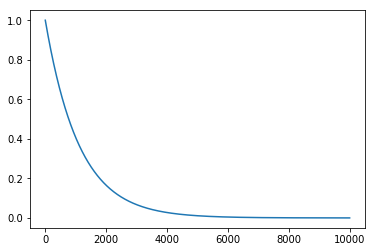

In [7]:
plt.plot(time, epsilon)
plt.show()